In [1]:
%env DDE_BACKEND=tensorflow
import deepxde as dde
import numpy as np
import gc
import matplotlib.pyplot as plt
SEED=0xdde

env: DDE_BACKEND=tensorflow


2023-10-02 15:51:57.395470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def f1(x):
    return x * np.sin(5 * x)

# First establish the models

Set the default float type to float16
Compiling model...
'compile' took 0.004529 s

Training model...



/usr/local/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step      Train loss    Test loss     Test metric   
0         [4.05e-01]    [3.54e-01]    [1.30e+00]    
1000      [2.68e-02]    [2.85e-02]    [3.69e-01]    
2000      [3.31e-03]    [2.94e-03]    [1.19e-01]    
3000      [2.18e-03]    [1.86e-03]    [9.44e-02]    
4000      [1.89e-03]    [1.57e-03]    [8.67e-02]    
5000      [1.67e-03]    [1.36e-03]    [8.06e-02]    
6000      [1.59e-03]    [1.30e-03]    [7.90e-02]    
7000      [1.56e-03]    [1.27e-03]    [7.79e-02]    
8000      [1.52e-03]    [1.23e-03]    [7.67e-02]    
9000      [1.50e-03]    [1.31e-03]    [7.92e-02]    
10000     [1.48e-03]    [1.29e-03]    [7.87e-02]    

Best model at step 10000:
  train loss: 1.48e-03
  test loss: 1.29e-03
  test metric: [7.87e-02]

'train' took 15.327805 s



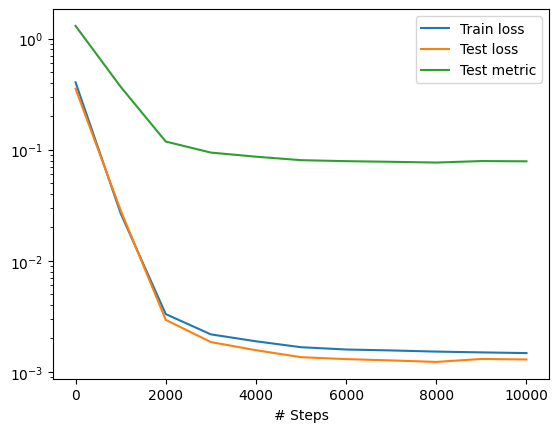

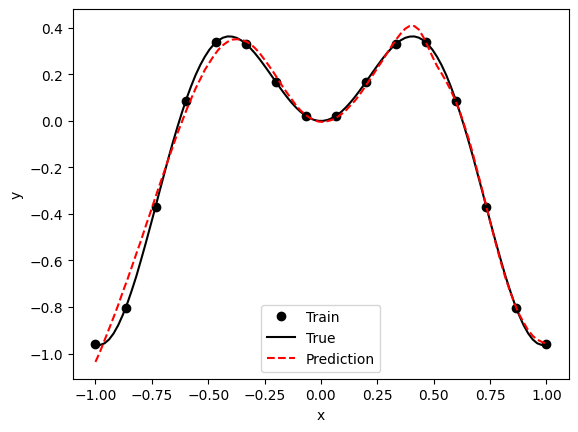

In [3]:
dde.config.set_random_seed(SEED)
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [10] * 2 + [1], activation, initializer)
model16 = dde.Model(data, net)
model16.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model16.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)


Set the default float type to float32
Compiling model...
'compile' took 0.006629 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    
1000      [3.19e-02]    [3.39e-02]    [4.03e-01]    
2000      [2.43e-04]    [2.43e-04]    [3.41e-02]    
3000      [1.19e-04]    [1.49e-04]    [2.67e-02]    
4000      [8.85e-05]    [1.25e-04]    [2.44e-02]    
5000      [7.70e-05]    [1.13e-04]    [2.33e-02]    
6000      [6.54e-05]    [1.00e-04]    [2.19e-02]    
7000      [5.30e-05]    [8.62e-05]    [2.03e-02]    
8000      [4.12e-05]    [7.27e-05]    [1.87e-02]    
9000      [3.16e-05]    [6.00e-05]    [1.69e-02]    
10000     [3.72e-05]    [6.83e-05]    [1.81e-02]    

Best model at step 9000:
  train loss: 3.16e-05
  test loss: 6.00e-05
  test metric: [1.69e-02]

'train' took 15.137169 s



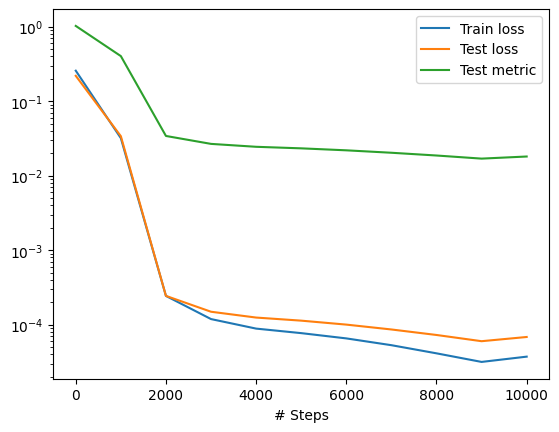

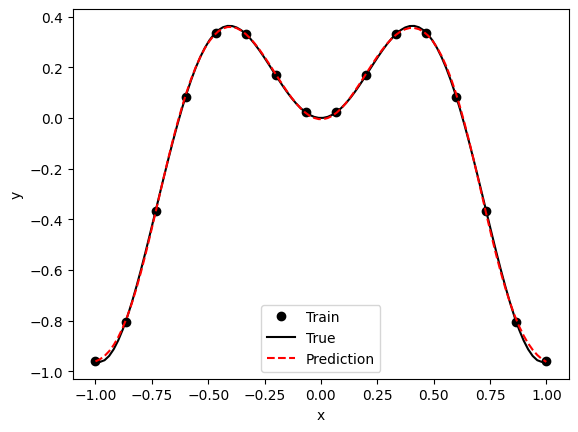

In [4]:
dde.config.set_random_seed(SEED)
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [10] * 2 + [1], activation, initializer)
model32 = dde.Model(data, net)
model32.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model32.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [6]:
#Landscapeviz code for ease of changing to work with deepxde
import logging
import gc
import os

import h5py
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA

# from .trajectory import load_weights, weight_encoder


def get_vectors(model, seed=None, trajectory=None):

    np.random.seed(seed)
    vector_x, vector_y = list(), list()
    weights = model.get_weights()

    if trajectory:
        # this has to be re-written
        load_weights(model, trajectory)
        file_path = os.path.join(trajectory, ".trajectory", "model_weights.hdf5")

        with h5py.File(file_path, "r+") as f:
            differences = list()
            trajectory = np.array(f["weights"])
            for i in range(0, len(trajectory) - 1):
                differences.append(trajectory[i] - trajectory[-1])

            pca = PCA(n_components=2)
            pca.fit(np.array(differences))
            f["X"], f["Y"] = pca.transform(np.array(differences)).T

        vector_x = weight_encoder(model, pca.components_[0])
        vector_y = weight_encoder(model, pca.components_[1])

        return weights, vector_x, vector_y

    else:
        cast = np.array([1]).T
        for layer in weights:
            # set standard normal parameters
            # filter-wise normalization
            k = len(layer.shape) - 1
            d = np.random.multivariate_normal([0], np.eye(1), layer.shape).reshape(
                layer.shape
            )
            dist_x = (
                d / (1e-10 + cast * np.linalg.norm(d, axis=k))[:, np.newaxis]
            ).reshape(d.shape)

            vector_x.append(
                (
                    dist_x * (cast * np.linalg.norm(layer, axis=k))[:, np.newaxis]
                ).reshape(d.shape)
            )

            d = np.random.multivariate_normal([0], np.eye(1), layer.shape).reshape(
                layer.shape
            )
            dist_y = (
                d / (1e-10 + cast * np.linalg.norm(d, axis=k))[:, np.newaxis]
            ).reshape(d.shape)

            vector_y.append(
                (
                    dist_y * (cast * np.linalg.norm(layer, axis=k))[:, np.newaxis]
                ).reshape(d.shape)
            )
        gc.collect()
        return weights, vector_x, vector_y


def _obj_fn(model, data, solution):

    old_weights = model.get_weights()
    model.set_weights(solution)
    value = model.evaluate(data[0], data[1], verbose=0)
    model.set_weights(old_weights)

    return value


def build_mesh(
    model,
    data,
    grid_length,
    extension=1,
    filename="meshfile",
    verbose=True,
    seed=None,
    trajectory=None,
    predicted=None
):

    logging.basicConfig(level=logging.INFO)

    Z = list()

    # get vectors and set spacing
    origin, vector_x, vector_y = get_vectors(model, seed=seed, trajectory=trajectory)
    space = np.linspace(-extension, extension, grid_length)

    X, Y = np.meshgrid(space, space)

    for i in range(grid_length):
        if verbose:
            logging.info("line {} out of {}".format(i, grid_length))

        for j in range(grid_length):
            solution = [
                origin[x] + X[i][j] * vector_x[x] + Y[i][j] * vector_y[x]
                for x in range(len(origin))
            ]

            Z.append(_obj_fn(model, data, solution))
        gc.collect()
    gc.collect()
    Z = np.array(Z)
    os.makedirs("./files", exist_ok=True)

    with h5py.File("./files/{}.hdf5".format(filename), "w") as f:
        f["space"] = space
        original_results = _obj_fn(model, data, origin)
        f["original_" + "MSE"] = original_results
        f["MSE"] = Z.reshape(X.shape)
        if type(predicted) != type(None):
            f['X_TEST'] = predicted[0]
            f['Y_TEST_PREDICTED'] = predicted[1]
        f.close()

    del Z
    gc.collect()

In [7]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

FILENAME = "./files/meshfile.hdf5"


def _fetch_data(key, filename):

    if filename[-5:] != ".hdf5":
        filename += ".hdf5"

    with h5py.File(filename, "r") as f:
        space = np.asarray(f["space"])
        Z = np.array(f[key])

    X, Y = np.meshgrid(space, space)
    return X, Y, Z


def plot_contour(
    key, lines=(.0001, 1, 25), trajectory=None, filename=FILENAME, save=None, title=None,
):

    X, Y, Z = _fetch_data(key, filename)

    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z, cmap="jet", levels=np.linspace(lines[0], lines[1], lines[2]))
    ax.clabel(CS, inline=1, fontsize=8)

    if trajectory:
        with h5py.File(
            os.path.join(trajectory, ".trajectory", "model_weights.hdf5"), "r"
        ) as f:
            ax.plot(np.array(f["X"]), np.array(f["Y"]), marker=".")
    if title != None:
        plt.title(label=title)
    fig.patch.set_facecolor('white')

    if save:
        fig.savefig(save)

    plt.show()


def plot_grid(key, filename=FILENAME, save=None, title=None):
    X, Y, Z = _fetch_data(key, filename)
    fig, _ = plt.subplots()

    plt.imshow(
        Z, interpolation="none", cmap='jet', extent=[X.min(), X.max(), Y.min(), Y.max()]
    )
    plt.colorbar()
    if title != None:
        plt.title(label=title)
    fig.patch.set_facecolor('white')

    if save:
        fig.savefig(save)

    plt.show()


def plot_3d(key, filename=FILENAME, log=False, save=None, title=None):

    X, Y, Z = _fetch_data(key, filename)

    if log:
        Z = np.log(Z + 0.1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface.
    surf = ax.plot_surface(
        X, Y, Z, cmap='jet', linewidth=0, antialiased=False
    )
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title != None:
        plt.title(label=title)
    fig.patch.set_facecolor('white')
    if save:
        fig.savefig(save)

    plt.show()

# Plot The Loss Landscapes
Using https://github.com/artur-deluca/landscapeviz because it supports tensorflow 2.

In [8]:
from deepxde import losses
# this is the default loss fn
mse = losses.get("MSE")
model16.net.compile(loss=mse)
model16.net.loss = "MSE"
build_mesh(model16.net,(model16.data.train_x,model16.data.train_y),grid_length=40,seed=SEED,verbose=False,extension=.1,filename="mesh16")

Exception ignored in: <function AtomicFunction.__del__ at 0x1169ecae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 291, in __del__
    self._bound_context.remove_function(self.name)
  File "/usr/local/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 1457, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
plot_contour("MSE",filename="files/mesh16.hdf5")
plot_grid("MSE", filename="files/mesh16.hdf5")
plot_3d("MSE", filename="files/mesh16.hdf5")

In [ ]:
from deepxde import losses
# this is the default loss fn
mse = losses.get("MSE")
model32.net.compile(loss=mse)
model32.net.loss = "MSE"
build_mesh(model32.net,(model32.data.train_x,model32.data.train_y),grid_length=40,seed=SEED,verbose=False,extension=.1,filename="mesh32")

In [ ]:
plot_contour("MSE", filename="files/mesh32.hdf5")
plot_grid("MSE", filename="files/mesh32.hdf5")
plot_3d("MSE", filename="files/mesh32.hdf5")

# Now try to make a 16 bit FNN with the same weights as a 32 bit FNN (just truncated)
Having a determinstic random seed is not enough; we need the weights (and the loss landscape) to start the same so that we can see how (any why) they diverge.

Set the default float type to float32
Compiling model...
'compile' took 0.003375 s

Set the default float type to float16
Compiling model...
'compile' took 0.005170 s



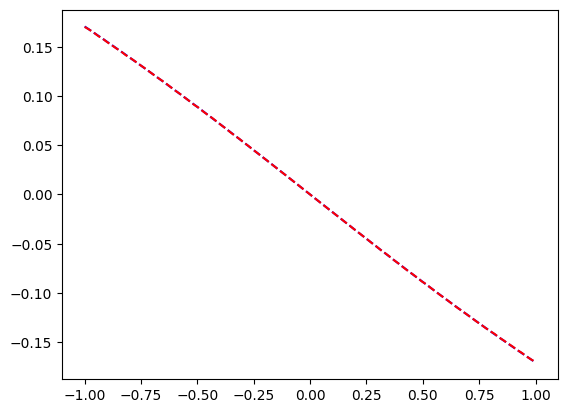

In [9]:
import deepxde as dde
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
dde.config.set_random_seed(SEED)
#
# Create the original model as float32
#
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model32_to_copy = dde.Model(data, net)
model32_to_copy.compile("adam", lr=0.001, metrics=["l2 relative error"])
# print the original weights
# generate the test arrays
_ = model32_to_copy.data.test()
# do one evaluation to initialize the weights
_ = model32_to_copy.predict([[1]])


#
# create a new model, but float16
#
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model16_new = dde.Model(data, net)
model16_new.compile("adam", lr=0.001, metrics=["l2 relative error"])

# generate the test arrays
_ = model16_new.data.test()
# do one evaluation to initialize the weights
_ = model16_new.predict([[1]])
# copy the weights
for i, layer in enumerate(model32_to_copy.net.denses):
    model16_new.net.denses[i].set_weights([tf.cast(w, dtype=tf.float16) for w in layer.get_weights()])
# make sure it worked by plotting the function with no training; should be the same as the first plot; they should overlap perfectly
plt.plot(model32_to_copy.data.test_x, model32_to_copy.predict(model32_to_copy.data.test_x), 'b--')
plt.plot(model16_new.data.test_x, model16_new.predict(model16_new.data.test_x), 'r--')
plt.show()
class SaveLosslandscapeCallback(dde.callbacks.Callback):
    def __init__(self, name, resolution=20, period=700, total_epochs=0):
        super().__init__()
        self.name = name
        self.period = period
        self.epochs_since_last_save = 0
        self.total_epochs = total_epochs
        self.resolution = resolution
    def on_epoch_begin(self):
        self.total_epochs += 1
        self.epochs_since_last_save += 1
        # since a lot of the gradient descent happens in the first 100 epochs, capture that
        if self.epochs_since_last_save < self.period and self.total_epochs not in range(0,100,5) and self.total_epochs not in range(0,5):
            return
        self.epochs_since_last_save = 0
        from deepxde import losses
        mse = losses.get("MSE")
        self.model.net.compile(loss=mse)
        self.model.net.loss = "MSE"
        print(f'\nGENERATING mesh after epoch {self.total_epochs}...; saving to ./files/{self.name}_epoch_{self.total_epochs}.hdf5\n')
        build_mesh(
            self.model.net,(self.model.data.train_x,self.model.data.train_y),
            grid_length=self.resolution,seed=SEED,verbose=False,extension=1,
            filename=f"{self.name}_epoch_{self.total_epochs}",
            predicted=(self.model.data.test_x, self.model.predict(self.model.data.test_x))
        )
        gc.collect()

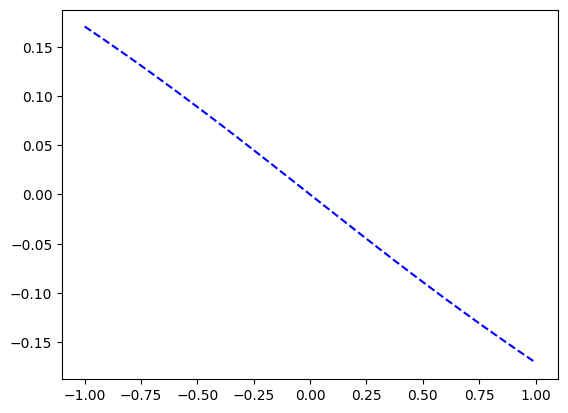

Set the default float type to float32
Training model...

Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    
25        [2.28e-01]    [2.04e-01]    [9.88e-01]    
50        [2.23e-01]    [1.98e-01]    [9.74e-01]    
75        [2.19e-01]    [1.95e-01]    [9.66e-01]    
100       [2.12e-01]    [1.89e-01]    [9.52e-01]    
125       [2.02e-01]    [1.80e-01]    [9.29e-01]    
150       [1.86e-01]    [1.67e-01]    [8.93e-01]    
175       [1.64e-01]    [1.47e-01]    [8.40e-01]    
200       [1.37e-01]    [1.24e-01]    [7.71e-01]    
225       [1.09e-01]    [1.00e-01]    [6.93e-01]    
250       [8.42e-02]    [7.97e-02]    [6.18e-01]    
275       [6.69e-02]    [6.56e-02]    [5.61e-01]    
300       [5.75e-02]    [5.83e-02]    [5.28e-01]    
325       [5.30e-02]    [5.48e-02]    [5.12e-01]    
350       [5.04e-02]    [5.25e-02]    [5.01e-01]    
375       [4.86e-02]    [5.08e-02]    [4.93e-01]    
400       [4.71e-02]    [4.94e-02]    [4.8

In [10]:
plt.plot(model32_to_copy.data.test_x, model32_to_copy.predict(model32_to_copy.data.test_x), 'b--')
plt.show()

dde.config.set_default_float('float32')
model32_to_copycallbacks = [SaveLosslandscapeCallback(name="model32_to_copy", period=20)]
model32_to_copycallbacks = []
# model32_to_copycallbacks = []
losshistory, train_state = model32_to_copy.train(iterations=10_000, callbacks=model32_to_copycallbacks,display_every=25)

Set the default float type to float16


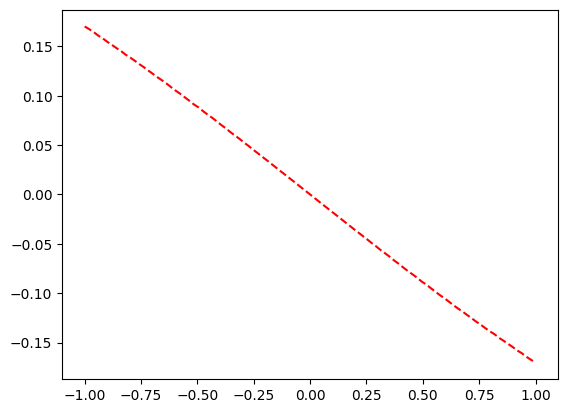

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.57e-01]    [2.19e-01]    [1.02e+00]    
25        [1.99e-01]    [1.75e-01]    [9.16e-01]    
50        [1.22e-01]    [1.10e-01]    [7.26e-01]    
75        [5.26e-02]    [4.90e-02]    [4.84e-01]    
100       [3.86e-02]    [3.73e-02]    [4.23e-01]    
125       [3.23e-02]    [3.15e-02]    [3.88e-01]    
150       [2.82e-02]    [2.74e-02]    [3.62e-01]    
175       [2.67e-02]    [2.72e-02]    [3.61e-01]    
200       [2.26e-02]    [2.27e-02]    [3.30e-01]    
225       [2.05e-02]    [2.06e-02]    [3.14e-01]    
250       [1.95e-02]    [2.01e-02]    [3.10e-01]    
275       [1.90e-02]    [1.92e-02]    [3.03e-01]    
300       [1.91e-02]    [1.94e-02]    [3.05e-01]    
325       [1.77e-02]    [1.80e-02]    [2.94e-01]    
350       [1.45e-02]    [1.53e-02]    [2.70e-01]    
375       [1.43e-02]    [1.53e-02]    [2.71e-01]    
400       [1.29e-02]    [1.40e-02]    [2.59e-01]    
425       [1.25e-02]    [1.

In [11]:
dde.config.set_default_float('float16')

plt.plot(model16_new.data.test_x, model16_new.predict(model16_new.data.test_x), 'r--')
plt.show()

model16_newcallbacks = [SaveLosslandscapeCallback(name="model16_new", period=20)]
model16_newcallbacks = []
losshistory, train_state = model16_new.train(iterations=10_000, callbacks=model16_newcallbacks,display_every=25)

# Data analysis to display the results (movie???)

In [ ]:
import glob
from natsort import natsorted
import re
extract_num_from_fname = re.compile('epoch_([0-9]+)')
_ = model16_new.data.train_next_batch()
def fetch_test_and_predicted(filename):
    if filename[-5:] != ".hdf5":
        filename += ".hdf5"

    with h5py.File(filename, "r") as f:
        test, predicted = f['X_TEST'], f["Y_TEST_PREDICTED"]
        test_copy = np.array(test)
        predicted_copy = np.array(predicted)
    return test_copy, predicted_copy
# we sort them naturally based on the numbers
files16 = natsorted(glob.glob("files/model16_new*"))
files32 = natsorted(glob.glob("files/model32_to_copy*"))
models_state_images = []
ll_16_images = []
ll_32_images = []
print(files16,files32)
for (file16, file32) in zip(files16, files32):
    x16, predicted16 = fetch_test_and_predicted(file16)
    x32, predicted32 = fetch_test_and_predicted(file32)
    epoch = extract_num_from_fname.search(file16).group(1)
    fig, _ = plt.subplots()
    plt.plot(x16, predicted16, 'r--', label="model16")
    plt.plot(x32, predicted32, 'b--', label="model32")
    plt.plot(model16_new.data.train_x, model16_new.data.train_y, 'g.', label="training")
    plt.legend()
    plt.title(label="epoch " + epoch)
    plt.show()
    fig.patch.set_facecolor('white')
    fig.savefig(f"./images/train_state_16_32_epoch_{epoch}.png")
    models_state_images.append(f"./images/train_state_16_32_epoch_{epoch}.png")
    plot_grid('MSE', filename=file16, title=f"float16 epoch {epoch}", save=f"./images/epoch_{epoch}_16_losslandscape.png")
    ll_16_images.append(f"./images/epoch_{epoch}_16_losslandscape.png")
    plot_grid('MSE', filename=file32, title=f"float32 epoch {epoch}", save=f"./images/epoch_{epoch}_32_losslandscape.png")
    ll_32_images.append(f"./images/epoch_{epoch}_32_losslandscape.png")

In [ ]:
%env FFMPEG_BINARY='/nix/store/1cnb9x64rmmbbnvbj5pl9syg58bmxq1v-home-manager-path/bin/ffmpeg'
import moviepy
from moviepy.editor import *
assert len(models_state_images) == len(ll_16_images) == len(ll_32_images)
model_state_evolution = ImageSequenceClip(models_state_images,fps=24,durations=[.2 for _ in range(len(models_state_images))])
ll_16_evolution = ImageSequenceClip(ll_16_images,fps=24,durations=[.2 for _ in range(len(ll_16_images))])
ll_32_evolution = ImageSequenceClip(ll_32_images,fps=24,durations=[.2 for _ in range(len(ll_32_images))])
final_clip=clips_array([[model_state_evolution, model_state_evolution], [ll_16_evolution, ll_32_evolution]])
final_clip.write_videofile('./movies/xsin5x_up_10_000_3d.mp4', fps=24)

# Transfer the weieghts from float32 to 16

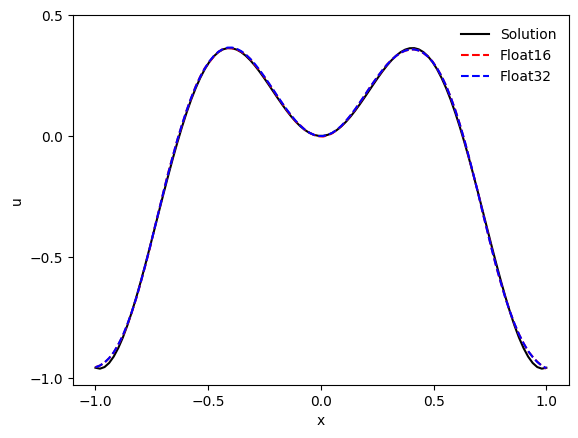

In [23]:
for i, layer in enumerate(model32.net.denses):
    model16.net.denses[i].set_weights([tf.cast(w, dtype=tf.float16) for w in layer.get_weights()])
# make sure it worked; they should overlap perfectly
space = np.linspace(-1,1,100)[:,np.newaxis]
plt.plot(space, f1(space), 'k-', label="Solution")
plt.plot(space, model16.predict(space), 'r--', label="Float16")
plt.plot(space, model32.predict(space), 'b--', label="Float32")
plt.legend(frameon=False)
plt.xlabel('x')
plt.xticks([-1, -.5, 0, .5, 1])
plt.yticks([-1, -.5, 0, .5])
plt.ylabel('u')
plt.savefig("casting_weights.pdf")
plt.show()
# they do! it must be some sort of optimization error!!!

# Transfer the weights to float16 after n epochs

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
dde.config.set_random_seed(SEED)
#
# Create the original model as float32
#
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model32 = dde.Model(data, net)
model32.compile("adam", lr=0.001, metrics=["l2 relative error"])
# print the original weights
# generate the test arrays
_ = model32.data.test()
_ = model32.data.train_next_batch()
# do one evaluation to initialize the weights
_ = model32.predict([[1]])


#
# create a new model, but float16
#
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model16 = dde.Model(data, net)
model16.compile("adam", lr=0.001, metrics=["l2 relative error"])

# generate the test arrays
_ = model16.data.test()
_ = model16.data.train_next_batch()

# do one evaluation to initialize the weights
_ = model16.predict([[1]])
def get_gradients_of_weights(model16):
    # get the gradients of the weights at the beginning, and compare them
    x_train = model16.data.train_x
    y_train = model16.data.train_y
    with tf.GradientTape() as tape:
        y_pred = model16.net.call(x_train)
        loss_fn = dde.losses.get("MSE")
        loss = loss_fn(y_train, y_pred)
    gradients16 = tape.gradient(loss,model16.net.trainable_weights)
    gradients161d = np.concatenate([gradient.numpy().ravel() for gradient in gradients16])
    return gradients161d
def get_cosine_similarity_of_model_gradients(g16, g32):
    def cosine_similarity(vector1, vector2):
        dot_product = np.dot(vector1, vector2)
        norm_vector1 = np.linalg.norm(vector1)
        norm_vector2 = np.linalg.norm(vector2)
        return dot_product / (norm_vector1 * norm_vector2)
    csim = cosine_similarity(g16, g32)
    dist = np.linalg.norm(g16 - g32)

    return csim, dist

def get_cosine_similarity_of_models(model16, model32):
    dde.config.set_default_float('float16')
    gradients161d = get_gradients_of_weights(model16)
    # print(gradients161d)
    dde.config.set_default_float('float32')
    gradients321d = get_gradients_of_weights(model32)
    #     print(gradients321d)
    cos_sim, dist = get_cosine_similarity_of_model_gradients(gradients321d, gradients161d)
    l2_rel_error = dist/np.linalg.norm(gradients321d)
    print('cosine_similarity', cos_sim)
    print('euclidian distance',dist)
    print('l2 rel error (dist/|g32|)', l2_rel_error)
    print(f'[{cos_sim}, {dist}, {l2_rel_error}],')
class SaveGradientsCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.list_of_weights = []
    def on_epoch_begin(self):
        self.list_of_weights.append(get_gradients_of_weights(self.model))
get_cosine_similarity_of_models(model16, model32)
n = 0
dde.config.set_default_float('float32')

cback32 = SaveGradientsCallback()
losshistory, train_state = model32.train(iterations=n,display_every=500, callbacks=[cback32])

for i, layer in enumerate(model32.net.denses):
    model16.net.denses[i].set_weights(
        [tf.cast(w, dtype=tf.float16) for w in layer.get_weights()]
    )
get_cosine_similarity_of_models(model16, model32) # this should be one
losshistory, train_state = model32.train(iterations=10_000 - n,display_every=500, 
                                         callbacks=[cback32]
)
dde.config.set_default_float('float16')
cback16 = SaveGradientsCallback()
losshistory, train_state = model16.train(iterations=10_000 - n,display_every=500, callbacks=[cback16])
get_cosine_similarity_of_models(model16, model32)

cos_similarity = []
grad_mags = []
for grads16, grads32 in zip(cback16.list_of_weights,cback32.list_of_weights[n:]):
    csim, dist = get_cosine_similarity_of_model_gradients(grads16, grads32)
    grad_mags.append([np.linalg.norm(grads16), np.linalg.norm(grads32)])
    cos_similarity.append(csim)
grad_mags = np.array(grad_mags)
print(grad_mags.shape)
plt.xlabel('epochs')
plt.ylabel('cos(angle between gradients)')
plt.title('cosine similarity between half and single precision gradients')
plt.plot(np.linspace(n,10_000, 10_000-n),cos_similarity)
plt.show()

fig, ax = plt.subplots()

ax.plot(np.linspace(n, 10_000, 10_000-n), grad_mags[:,0], label="magnitude of gradients of half-precision weights")
ax.plot(np.linspace(n, 10_000, 10_000-n), grad_mags[:,1], label="magnitude of gradients of single-precision weights")
plt.title('magnitude of gradients')
ax.set_yscale('log')
plt.xlabel('epochs')
plt.ylabel('magnitude of gradients')
plt.legend()
ax.show()

# plot them together
space = np.linspace(-1,1,100)[:,np.newaxis]
plt.plot(space, f1(space), 'g-', label="solution")
plt.plot(space, model32.predict(space), 'b--', label="model32")
plt.plot(space, model16.predict(space), 'r--', label="model16")
plt.title(label=f"transfer weights after {n} epochs")
plt.legend()
plt.show()

In [ ]:
# manually collected data from cell above with different seeds
data_for_cos_sim_dist_rel_error = np.array([
    [0.18367311358451843, 3.2268753051757812, 1.0405014753341675],
    [-0.030301902443170547, 1.8343915939331055, 2.076207160949707],
    [-0.09829698503017426, 2.611952543258667, 1.4349809885025024],
    [0.44221293926239014, 0.9062069058418274, 1.1032211780548096],
    [0.34074005484580994, 1.199136734008789, 0.973371684551239],
    [-0.21835772693157196, 3.845982313156128, 1.5164756774902344],
    [0.3196358382701874, 1.0769842863082886, 1.2643898725509644],
    [0.16375499963760376, 3.013840913772583, 4.972597599029541],
    [0.17529626190662384, 1.5245580673217773, 1.28493332862854],
    [0.3472341299057007, 1.2002012729644775, 1.031378149986267],
])
mu = data_for_cos_sim_dist_rel_error.mean(axis=0)
sigma = data_for_cos_sim_dist_rel_error.std(axis=0)
print(list(zip(mu, sigma)))

In [ ]:
def hw2(x,):
    if x < 0:
        sum = 0
        for k in range(4):
            sum += np.sin((k+1)*x)
        sum += 5
        return sum
    elif x >= 0:
        return np.cos(10 * x)
hw64 = np.vectorize(hw2,otypes=[np.float64])
hw32 = np.vectorize(hw2,otypes=[np.float32])
hw16 = np.vectorize(hw2,otypes=[np.float16])
arch = [1] + [20] * 3 + [1]
# same thing but with n = 5
dde.config.set_random_seed(SEED)
#
# Create the original model as float32
#
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-np.pi, np.pi)
data = dde.data.Function(geom, hw32, 200, 500)

net = dde.nn.FNN(arch, "tanh", "Glorot uniform")
model32 = dde.Model(data, net)
model32.compile("adam", lr=0.001, metrics=["l2 relative error"])
# print the original weights
# generate the test arrays
_ = model32.data.test()
_ = model32.data.train_next_batch()
# do one evaluation to initialize the weights
_ = model32.predict([[1]])


#
# create a new model, but float16
#
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-np.pi, np.pi)
data = dde.data.Function(geom, hw16, 200, 500)

net = dde.nn.FNN(arch, "tanh", "Glorot uniform")
model16 = dde.Model(data, net)
model16.compile("adam", lr=0.001, metrics=["l2 relative error"])

# generate the test arrays
_ = model16.data.test()
_ = model16.data.train_next_batch()

# do one evaluation to initialize the weights
_ = model16.predict([[1]])
def get_gradients_of_weights(model16):
    # get the gradients of the weights at the beginning, and compare them
    x_train = model16.data.train_x
    y_train = model16.data.train_y
    with tf.GradientTape() as tape:
        y_pred = model16.net.call(x_train)
        loss_fn = dde.losses.get("MSE")
        loss = loss_fn(y_train, y_pred)
    gradients16 = tape.gradient(loss,model16.net.trainable_weights)
    gradients161d = np.concatenate([gradient.numpy().ravel() for gradient in gradients16])
    return gradients161d
def get_cosine_similarity_of_model_gradients(g16, g32):
    def cosine_similarity(vector1, vector2):
        dot_product = np.dot(vector1, vector2)
        norm_vector1 = np.linalg.norm(vector1)
        norm_vector2 = np.linalg.norm(vector2)
        return dot_product / (norm_vector1 * norm_vector2)
    csim = cosine_similarity(g16, g32)
    dist = np.linalg.norm(g16 - g32)

    return csim, dist

def get_cosine_similarity_of_models(model16, model32):
    dde.config.set_default_float('float16')
    gradients161d = get_gradients_of_weights(model16)
    # print(gradients161d)
    dde.config.set_default_float('float32')
    gradients321d = get_gradients_of_weights(model32)
    #     print(gradients321d)
    cos_sim, dist = get_cosine_similarity_of_model_gradients(gradients321d, gradients161d)
    print('cosine_similarity', cos_sim)
    print('euclidian distance',dist)
class SaveGradientsCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.list_of_weights = []
    def on_epoch_begin(self):
        self.list_of_weights.append(get_gradients_of_weights(self.model))
get_cosine_similarity_of_models(model16, model32)
n = 100
dde.config.set_default_float('float32')

cback32 = SaveGradientsCallback()
losshistory, train_state = model32.train(iterations=n,display_every=500, callbacks=[cback32])

for i, layer in enumerate(model32.net.denses):
    model16.net.denses[i].set_weights(
        [tf.cast(w, dtype=tf.float16) for w in layer.get_weights()]
    )
get_cosine_similarity_of_models(model16, model32) # this should be one
losshistory, train_state = model32.train(iterations=10_000 - n,display_every=500, 
                                         callbacks=[cback32]
)
dde.config.set_default_float('float16')
cback16 = SaveGradientsCallback()
losshistory, train_state = model16.train(iterations=10_000 - n,display_every=500, callbacks=[cback16])
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

get_cosine_similarity_of_models(model16, model32)

cos_similarity = []
grad_mags = []
for grads16, grads32 in zip(cback16.list_of_weights,cback32.list_of_weights[n:]):
    csim, dist = get_cosine_similarity_of_model_gradients(grads16, grads32)
    grad_mags.append([np.linalg.norm(grads16), np.linalg.norm(grads32)])
    cos_similarity.append(csim)
grad_mags = np.array(grad_mags)
print(grad_mags.shape)
plt.xlabel('epochs')
plt.ylabel('cos(angle between gradients)')
plt.title('cosine similarity between half and single precision gradients')
plt.plot(np.linspace(n,10_000, 10_000-n),cos_similarity)
plt.show()
plt.plot(np.linspace(n, 10_000, 10_000-n), grad_mags[:,0], label="magnitude of gradients of half-precision weights")
plt.plot(np.linspace(n, 10_000, 10_000-n), grad_mags[:,1], label="magnitude of gradients of single-precision weights")
plt.title('magnitude of gradients')
plt.xlabel('epochs')
plt.ylabel('magnitude of gradients')
plt.legend()
plt.show()
# plot them together
space = np.linspace(-1,1,100)[:,np.newaxis]
plt.plot(space, f1(space), 'g-', label="solution")
plt.plot(space, model32.predict(space), 'b--', label="model32")
plt.plot(space, model16.predict(space), 'r--', label="model16")
plt.title(label=f"transfer weights after {n} epochs")
plt.legend()
plt.show()

In [ ]:
# We need to make a movie that starts for the first 5 epochs just float32, then splits in 2 to show float16 and float32

In [ ]:
# also do it for hw2

In [ ]:
from deepxde import losses
def hw2(x,):
    if x < 0:
        sum = 0
        for k in range(4):
            sum += np.sin((k+1)*x)
        sum += 5
        return sum
    elif x >= 0:
        return np.cos(10 * x)
hw32 = np.vectorize(hw2,otypes=[np.float32])
hw16 = np.vectorize(hw2,otypes=[np.float16])
def get_ll(func16, func32, n, xl=-np.pi, xr=np.pi, arch=[1] + [20] * 3 + [1], num_train=200, num_test=500, isplot=True):
    activation = "tanh"
    initializer = "Glorot uniform"
    mse = losses.get("MSE")

    dde.config.set_default_float('float32')
    geom = dde.geometry.Interval(xl, xr)
    data = dde.data.Function(geom, func32, num_train, num_test)
    net = dde.nn.FNN(arch, activation, initializer)
    model32 = dde.Model(data, net)
    model32.compile("adam", lr=0.001, metrics=["l2 relative error"])
    losshistory, train_state = model32.train(iterations=n, display_every=100)
    model32.net.compile(loss=mse)
    model32.net.loss = "MSE"
    build_mesh(model32.net,(model32.data.train_x,model32.data.train_y),grid_length=35,seed=SEED,verbose=False,extension=1,filename=f"hw2_mesh_float32")
    plot_grid("MSE", filename=f"files/hw2_mesh_float32.hdf5", title=f'float32 epoch {n+1}')
    
    # make model16 and copy weights
    dde.config.set_default_float('float16')
    geom = dde.geometry.Interval(xl, xr)
    data = dde.data.Function(geom, func16, num_train, num_test)
    net = dde.nn.FNN(arch, activation, initializer)
    model16 = dde.Model(data, net)
    model16.compile("adam", lr=0.001, metrics=["l2 relative error"])
    # generate the test arrays
    _ = model16.data.test()
    _ = model16.data.train_next_batch()
    # do one evaluation to initialize the weights
    _ = model16.predict([[1]])

    for i, layer in enumerate(model32.net.denses):
        model16.net.denses[i].set_weights(
            [tf.cast(w, dtype=tf.float16) for w in layer.get_weights()]
        )
    losshistory, train_state = model16.train(iterations=n, display_every=100)
    model16.net.compile(loss=mse)
    model16.net.loss = "MSE"
    build_mesh(model16.net,(model16.data.train_x,model16.data.train_y),grid_length=35,seed=SEED,verbose=False,extension=1,filename=f"hw2_mesh_float16")
    plot_grid("MSE", filename=f"files/hw2_mesh_float16.hdf5", title=f'float16 epoch {n+1}')

In [ ]:
# get_ll(hw16, hw32, 0, isplot=False)
get_ll(hw16, hw32, 3, isplot=False)